# Imports

In [1]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import math
import glob
import h5py
import sys
import os

main_path = '/media/adalberto/Disk2/PhD_Workspace'
sys.path.append(main_path)
from models.clustering.logistic_regression_leiden_clusters import *
from models.evaluation.folds import load_existing_split
from models.clustering.correlations import *
from models.clustering.data_processing import *
from data_manipulation.utils import store_data


/home/adalberto/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/adalberto/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/adalberto/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/adalberto/.local/lib/python3.7/site-packages/tensorflow/python/framework/dty

# Variables for run comparison

In [2]:
# Workspace path.
main_path = '/media/adalberto/Disk2/PhD_Workspace'

# Resolution and fold for the tile clustering and slide representations.
resolution     = 2.0
fold_number    = 0
groupby        = 'leiden_%s' % resolution

# Folder run.
meta_folder    = 'luad_overall_survival_nn250_fold%s' % fold_number
matching_field = 'slides'
meta_field     = 'luad'

# HoverNet dataset annotations.
cell_names             = ['cell neoplastic', 'cell inflammatory', 'cell connective', 'cell dead']
dataset                = 'NYU_LUADall_5x'
magnification          = '20x'
annotation_restriction = 1

# Penalties for Cox regression and flag for usage.
use_cox        = True
alpha          = 1.0
alpha_2        = 1.0

# Pickle files.
folds_pickle_subtype  = '%s/utilities/files/LUAD/folds_LUAD_Institutions.pkl'     % main_path
folds_pickle_survival = '%s/utilities/files/LUAD/overall_survival_TCGA_folds.pkl' % main_path

# Tile representation files.
h5_complete_path   = '%s/results/BarlowTwins_3/TCGAFFPE_LUADLUSC_5x_60pc_250K/h224_w224_n3_zdim128_filtered/hdf5_TCGAFFPE_LUADLUSC_5x_60pc_he_complete_lungsubtype_survival_filtered.h5' % main_path
if 'luad' in meta_folder:
    h5_additional_path = '%s/results/BarlowTwins_3/TCGAFFPE_LUADLUSC_5x_60pc_250K/h224_w224_n3_zdim128_filtered/NYU300LUAD_Survival_5x_60pc/h224_w224_n3_zdim128/hdf5_NYU300LUAD_Survival_5x_60pc_he_train_overall_progression_free_surival_filtered.h5' % main_path
else:
    h5_additional_path = None

# Annotation files.
hovernet_csv     = '%s/datasets/HoverNet/%s/%s/%s_hovernet_annotations_5x.csv' % (main_path, dataset, magnification, dataset)
nyu_histosub_csv = '%s/utilities/files/LUAD//NYU_percentages_slides.csv' % main_path
tcga_annot_csv   = '%s/utilities/files/LUADLUSC/slide_information.csv' % main_path
tcga_immune_csv  = '%s/utilities/files/TCGA/TCGA_immune_landscape.csv' % main_path

# Run path.
main_cluster_path = h5_complete_path.split('hdf5_')[0]
main_cluster_path = os.path.join(main_cluster_path, meta_folder)
adatas_path       = os.path.join(main_cluster_path, 'adatas')
figure_path       = os.path.join(main_cluster_path, 'leiden_%s_fold%s' % (str(resolution).replace('.','p'),fold_number))
figure_path       = os.path.join(figure_path,       'figures')
if not os.path.isdir(figure_path):
    os.makedirs(figure_path)


### Cox Regression runs

In [3]:
# Cox run for coefficients.
coef_os_df  = None
coef_pfs_df = None
if use_cox:
    csv_cox = os.path.join(main_cluster_path, '%s_leiden_%s_alpha_%s_l1ratio_0p0_mintiles_100' % (meta_folder, resolution, str(alpha).replace('.','p')))
    csv_cox = os.path.join(csv_cox, 'leiden_%s_stats_all_folds.csv' % (str(resolution).replace('.','p')))

    # Read in regression coefficient file
    cox_df  = pd.read_csv(csv_cox)
    coef_os_df = cox_df[[groupby, 'coef', 'p']].copy(deep=True)

    if 'luad_overall_survival' in csv_cox:

        csv_cox = csv_cox.replace('luad_overall_survival_nn250', 'luad_progression_free_survival_nn250')
        csv_cox = csv_cox.replace('alpha_%s_l1' % (str(alpha).replace('.','p')), 'alpha_%s_l1' % (str(alpha_2).replace('.','p')))

        # Read in regression coefficient file
        cox_df  = pd.read_csv(csv_cox)
        coef_pfs_df = cox_df[[groupby, 'coef', 'p']].copy(deep=True)

### Annotation files

In [4]:
# Histological Subtype slide annotations.
nyu_histo_df                 = pd.read_csv(nyu_histosub_csv)
nyu_histo_df[matching_field] = nyu_histo_df[matching_field].astype(str)

# Immune landscape sample annotations.
immune_landscape_df = pd.read_csv(tcga_immune_csv)

# Slide information annotations.
slide_anno_df = pd.read_csv(tcga_annot_csv)

# HoverNet Annotations.
hovernet_df  = pd.read_csv(hovernet_csv)

### Representations: Slides and Tiles.

In [5]:
''' Get representations for slide representation correlations. '''
# Fold
folds = load_existing_split(folds_pickle_survival)
fold = folds[fold_number]

# Read cohort CSVs.
dataframes, complete_df, leiden_clusters   = read_csvs(adatas_path, matching_field, groupby, fold_number, fold, h5_complete_path, h5_additional_path, additional_as_fold=False, force_fold=None)
train_df, valid_df, test_df, additional_df = dataframes
additional_df['tiles'] = additional_df['tiles'].apply(lambda x: x.split('.jpeg')[0])

# Cross reference HoverNet and Cluster annotations.
annotated_df           = additional_df.merge(hovernet_df, how='inner', left_on=['slides', 'tiles'], right_on=['slides', 'tiles'])
cluster_anno_df        = annotated_df[annotated_df['annotated_20x_tile_count']>=annotation_restriction]

''' Get representations for slide representation correlations. '''
frames = build_cohort_representations(meta_folder, meta_field, matching_field, groupby, fold_number, folds_pickle_subtype, h5_complete_path, h5_additional_path, 'clr', 100)
complete_df, additional_complete_df, frame_clusters, frame_samples, features = frames
complete_df.columns            = complete_df.columns.astype(str)
if additional_complete_df is not None: additional_complete_df.columns = additional_complete_df.columns.astype(str)
# Check for duplicates, ways of handling them:
# 1. Drop duplicates.
# 2. Combine slides into one representations: This may include coming back from CLR and back after merged.
if len(np.unique(complete_df.samples)) != complete_df.shape[0]:
    # Easy option 1.
    complete_df = complete_df.drop_duplicates(subset='samples', keep="last")

''' Read clustering file '''
adata_train, h5ad_path = read_h5ad_reference(h5_complete_path, meta_folder, groupby, fold_number)

# Leiden clusters dendrogram.
leiden_linkage_method = 'average'
leiden_cor_method     = 'spearman'
sc.tl.dendrogram(adata_train, groupby, use_rep='X', linkage_method=leiden_linkage_method, cor_method=leiden_cor_method)
leiden_linkage = adata_train.uns['dendrogram_%s' % groupby]['linkage']

### Correlations

In [47]:
corr_method   = 'spearman'   # Correlation method.
corr_matching = 'samples'
pval_th       = 0.01

correlations_dict = dict()
'''Histological Subtype'''
if additional_complete_df is not None:
    file_name = h5_additional_path.split('/hdf5_')[1].split('.h5')[0] + '_%s__fold%s_%s_histsubtypes' % (groupby.replace('.', 'p'), fold_number, meta_folder)
    all_data_rho, all_data_pval, mask, _ = correlate_clusters_annotation(slide_rep_df=additional_complete_df, annotations_df=nyu_histo_df, purity_field=meta_field,
                                                                         matching_field=matching_field, corr_method=corr_method, pval_th=pval_th, groupby=groupby,
                                                                         fold_number=fold_number, directory=main_cluster_path, file_name=file_name)
    correlations_dict['histsubtypes'] = dict()
    correlations_dict['histsubtypes']['file_name'] = file_name
    correlations_dict['histsubtypes']['data']      = all_data_rho, all_data_pval, mask

''' Cluster Purity '''
if additional_complete_df is not None:
    file_name = h5_additional_path.split('/hdf5_')[1].split('.h5')[0] + '_%s__fold%s_%s_hovernet' % (groupby.replace('.', 'p'), fold_number, meta_folder)
    critical_coef, critical_ref, p_values = ks_test_cluster_purities(cluster_anno_df=annotated_df, fields=cell_names, groupby=groupby, fold_number=fold_number, directory=main_cluster_path,
                                                                     file_name=file_name, p_th=0.01, critical_values_flag=True)
    mask  = (np.abs(critical_coef)<=critical_ref)
    correlations_dict['hovernet_nyu'] = dict()
    correlations_dict['hovernet_nyu']['file_name'] = file_name
    correlations_dict['hovernet_nyu']['data']      = critical_coef, critical_ref, p_values, mask

''' Immune Landscape '''
file_name = h5_complete_path.split('/hdf5_')[1].split('.h5')[0] + '_%s__fold%s_%s_immunelandscape' % (groupby.replace('.', 'p'), fold_number, meta_folder)
all_data_rho, all_data_pval, mask, _ = correlate_clusters_annotation(slide_rep_df=complete_df, annotations_df=immune_landscape_df, purity_field=meta_field,
                                                                     matching_field=corr_matching, corr_method=corr_method, pval_th=pval_th, field_th=0.05*len(features),
                                                                     groupby=groupby, fold_number=fold_number, directory=main_cluster_path, file_name=file_name)
correlations_dict['immunelandscape'] = dict()
correlations_dict['immunelandscape']['file_name'] = file_name
correlations_dict['immunelandscape']['data']      = all_data_rho, all_data_pval, mask

''' Slide Annotation '''
file_name = h5_complete_path.split('/hdf5_')[1].split('.h5')[0] + '_%s__fold%s_%s_slideanno' % (groupby.replace('.', 'p'), fold_number, meta_folder)
all_data_rho, all_data_pval, mask, _ = correlate_clusters_annotation(slide_rep_df=complete_df, annotations_df=slide_anno_df, purity_field=meta_field, matching_field=corr_matching,
                                                                     corr_method=corr_method, pval_th=pval_th, groupby=groupby, fold_number=fold_number,
                                                                     directory=main_cluster_path, file_name=file_name)
correlations_dict['slideanno'] = dict()
correlations_dict['slideanno']['file_name'] = file_name
correlations_dict['slideanno']['data']      = all_data_rho, all_data_pval, mask

### Figures

In [57]:
def plot_clustermap(all_data_rho, mask, y_label, directory, file_name, figsize, annot=True, cox_os_clusters=None, cox_pfs_clusters=None, col_linkage=None, show_row_cols=False, show=False, p_th=0.05):
    with rc_context({'figure.figsize': figsize}):
        colors        = None
        colors_masked = None
        if coef_os_df is not None:
            # Column colors.
            coef_df   = cox_os_clusters.sort_values(by=groupby)
            cmap_PiYG = plt.cm.PiYG_r
            norm      = TwoSlopeNorm(vmin=coef_df['coef'].min(), vcenter=0, vmax=coef_df['coef'].max())
            column_os_colors              = pd.Series([cmap_PiYG(norm(coef)) for p, coef in zip(coef_df['p'], coef_df['coef'])], name='Cox Coefficient\nOverall Survival')
            column_os_colors_masked       = pd.Series([cmap_PiYG(norm(coef)) if p <p_th else cmap_PiYG(norm(0))[:3] for p, coef in zip(coef_df['p'], coef_df['coef'])], name='Cox Coefficient\nOverall Survival')
            column_os_colors_masked.index = coef_df[groupby].astype(str)
            column_os_colors.index        = coef_df[groupby].astype(str)
            colors        = column_os_colors
            colors_masked = column_os_colors_masked

            if cox_pfs_clusters is not None:
                cox_pfs_clusters = cox_pfs_clusters.sort_values(by=groupby)
                cmap_PiYG = plt.cm.PiYG_r
                norm      = TwoSlopeNorm(vmin=cox_pfs_clusters['coef'].astype(float).min(), vcenter=0, vmax=cox_pfs_clusters['coef'].astype(float).max())
                column_pfs_colors        = pd.Series([cmap_PiYG(norm(coef)) for p, coef in zip(cox_pfs_clusters['p'], cox_pfs_clusters['coef'])],
                                                     name='Cox Coefficient\nProgression Free Survival')
                column_pfs_colors_masked = pd.Series([cmap_PiYG(norm(coef)) if p <p_th else cmap_PiYG(norm(0))[:3] for p, coef in zip(cox_pfs_clusters['p'], cox_pfs_clusters['coef'])],
                                                     name='Cox Coefficient\nProgression Free Survival')
                column_pfs_colors.index        = coef_df[groupby].astype(str)
                column_pfs_colors_masked.index = coef_df[groupby].astype(str)

                colors = pd.concat([column_os_colors, column_pfs_colors],axis=1)
                colors_masked = pd.concat([column_os_colors_masked, column_pfs_colors_masked],axis=1)

        for name, col_colors in [('', colors), ('_masked', colors_masked)]:
            sns.set_theme(style='white')
            vref = np.max(np.abs(all_data_rho.values))
            if col_colors is not None:
                g = sns.clustermap(all_data_rho, vmin=-vref, vmax=vref, method='ward', metric='euclidean', annot=annot, mask=mask, col_colors=col_colors, col_linkage=col_linkage,
                                   cmap=sns.diverging_palette(250, 20, as_cmap=True), dendrogram_ratio=0.2, annot_kws={"size": 20},  yticklabels=True,  xticklabels=True)
            else:
                g = sns.clustermap(all_data_rho, vmin=-vref, vmax=vref, method='ward', metric='euclidean', annot=annot, mask=mask, col_linkage=col_linkage,
                                   cmap=sns.diverging_palette(250, 20, as_cmap=True), dendrogram_ratio=0.2, annot_kws={"size": 20},  yticklabels=True,  xticklabels=True)
            g.ax_heatmap.set_ylabel('\n%s' % y_label, fontsize=30)
            g.ax_heatmap.set_xlabel('\nCluster', fontsize=30)
            g._figure.set_size_inches(figsize[0] + 20, figsize[1] + 20)
            g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize=28)
            g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=28)
            g.ax_col_colors.set_yticklabels(g.ax_col_colors.get_ymajorticklabels(), fontsize=28)
            g.ax_cbar.tick_params(labelsize=28)
            if show:
                plt.show()
            else:
                plt.savefig('%s/%s' % (directory, file_name.replace('.jpg', '%s.jpg' % name)))
                plt.close(g._figure)

            if col_colors is None:
                break
    return g

In [58]:
''' Cluster Purity '''
if additional_complete_df is not None:
    file_name = correlations_dict['hovernet_nyu']['file_name']
    critical_coef, critical_ref, p_values, mask = correlations_dict['hovernet_nyu']['data']
    g = plot_clustermap(all_data_rho=np.round(critical_coef,2), mask=mask.values, y_label='Cell Annotations', cox_os_clusters=coef_os_df, cox_pfs_clusters=coef_pfs_df,
                    directory=figure_path, file_name=file_name+'.jpg', figsize=(50,10))
    correlations_dict['hovernet_nyu']['linkage'] = g.dendrogram_col.linkage

'''Histological Subtype'''
if additional_complete_df is not None:
    file_name = correlations_dict['histsubtypes']['file_name']
    all_data_rho, all_data_pval, mask = correlations_dict['histsubtypes']['data']
    g = plot_clustermap(all_data_rho=all_data_rho, mask=mask.values, y_label='Histological Subtype', cox_os_clusters=coef_os_df, cox_pfs_clusters=coef_pfs_df,
                    directory=figure_path, file_name=file_name+'.jpg', figsize=(37,10))
    correlations_dict['histsubtypes']['linkage'] = g.dendrogram_col.linkage
#
''' Immune Landscape '''
file_name = correlations_dict['immunelandscape']['file_name']
all_data_rho, all_data_pval, mask = correlations_dict['immunelandscape']['data']
g = plot_clustermap(all_data_rho=all_data_rho, mask=mask.values, y_label='Immune feature', cox_os_clusters=coef_os_df, cox_pfs_clusters=coef_pfs_df,
                directory=figure_path, file_name=file_name+'.jpg', figsize=(50,22))
correlations_dict['immunelandscape']['linkage'] = g.dendrogram_col.linkage

''' Slide Annotation '''
file_name = correlations_dict['slideanno']['file_name']
all_data_rho, all_data_pval, mask = correlations_dict['slideanno']['data']
g = plot_clustermap(all_data_rho=all_data_rho, mask=mask.values, y_label='Slide feature', cox_os_clusters=coef_os_df, cox_pfs_clusters=coef_pfs_df,
                directory=figure_path, file_name=file_name+'.jpg', figsize=(40,10), )
correlations_dict['slideanno']['linkage'] = g.dendrogram_col.linkage


In [68]:
'''Cross Dendrogram - Immune/HoverNet & HoverNet/Immune '''
if additional_complete_df is not None:
    file_name = correlations_dict['hovernet_nyu']['file_name'] + '_cross_immune'
    critical_coef, critical_ref, p_values, mask = correlations_dict['hovernet_nyu']['data']
    g = plot_clustermap(all_data_rho=np.round(critical_coef,2), mask=mask.values, y_label='Cell Annotations', cox_os_clusters=coef_os_df, cox_pfs_clusters=coef_pfs_df,
                        col_linkage=correlations_dict['immunelandscape']['linkage'], directory=figure_path, file_name=file_name+'.jpg', figsize=(50,10))

    file_name = correlations_dict['immunelandscape']['file_name'] + '_cross_hovernet'
    all_data_rho, all_data_pval, mask = correlations_dict['immunelandscape']['data']
    g = plot_clustermap(all_data_rho=all_data_rho, mask=mask.values, y_label='Immune feature', cox_os_clusters=coef_os_df, cox_pfs_clusters=coef_pfs_df,
                        col_linkage=correlations_dict['hovernet_nyu']['linkage'], directory=figure_path, file_name=file_name+'.jpg', figsize=(50,22))

'''Cross Dendrogram - Immune/Leiden & HoverNet/Leiden '''
if additional_complete_df is not None:
    file_name = correlations_dict['hovernet_nyu']['file_name'] + '_cross_leiden'
    critical_coef, critical_ref, p_values, mask = correlations_dict['hovernet_nyu']['data']
    g = plot_clustermap(all_data_rho=np.round(critical_coef,2), mask=mask.values, y_label='Cell Annotations', cox_os_clusters=coef_os_df, cox_pfs_clusters=coef_pfs_df,
                        col_linkage=leiden_linkage, directory=figure_path, file_name=file_name+'.jpg', figsize=(50,10))

file_name = correlations_dict['immunelandscape']['file_name'] + '_cross_leiden'
all_data_rho, all_data_pval, mask = correlations_dict['immunelandscape']['data']
g = plot_clustermap(all_data_rho=all_data_rho, mask=mask.values, y_label='Immune feature', cox_os_clusters=coef_os_df, cox_pfs_clusters=coef_pfs_df,
                    col_linkage=leiden_linkage, directory=figure_path, file_name=file_name+'.jpg', figsize=(50,22))


# HoverNet Figures

In [72]:
annotation_restriction = 1
cluster_anno_df     = annotated_df[annotated_df['annotated_20x_tile_count']>=annotation_restriction]

normalize = False
tile_reps_df = list()
tile_reps = cluster_anno_df[[groupby]+cell_names].to_numpy()
num_of_tiles = tile_reps.shape[0]
if normalize:
    tile_reps_cell = tile_reps[:, 1:]/tile_reps[:, 1:].sum(axis=1)[:, np.newaxis]
else:
    tile_reps_cell = tile_reps[:, 1:]
tile_reps_cell = tile_reps_cell.mean(axis=0)
tile_reps_df.append(['Mean'] + tile_reps_cell.tolist() + [num_of_tiles])

for cluster_id in np.unique(tile_reps[:, 0]):
    indxs = np.argwhere(tile_reps[:,0]==cluster_id)[:,0]
    num_of_tiles = indxs.shape[0]
    if normalize:
        tile_reps_cell = tile_reps[indxs, 1:]/tile_reps[indxs, 1:].sum(axis=1)[:, np.newaxis]
    else:
        tile_reps_cell = tile_reps[indxs, 1:]
    tile_reps_cell = tile_reps_cell.mean(axis=0)
    tile_reps_df.append([cluster_id] + tile_reps_cell.tolist() + [num_of_tiles])

tile_reps = pd.DataFrame(tile_reps_df, columns=['Cluster']+cell_names+['Num Tiles'])
tile_reps = tile_reps.set_index('Cluster')
tile_reps = tile_reps[tile_reps['Num Tiles'].values.astype(int)>400]
tile_reps

,cell neoplastic,cell inflammatory,cell connective,cell dead,Num Tiles
Cluster,,,,,
Mean,298.207811,26.616274,19.270929,163.236482,203064
0,527.580065,67.875623,12.806717,271.051354,4615
1,450.761964,116.725793,16.822343,370.825543,7188
2,113.454197,15.645766,24.654169,164.116493,21658
3,86.073188,16.430399,24.088427,81.762082,17981
4,132.425000,13.588000,31.155000,181.473000,1000
5,663.923001,25.892399,8.877591,184.581441,1013
6,426.946674,18.073525,33.492055,150.081336,3713
7,296.227435,23.460515,19.658296,172.488547,15411


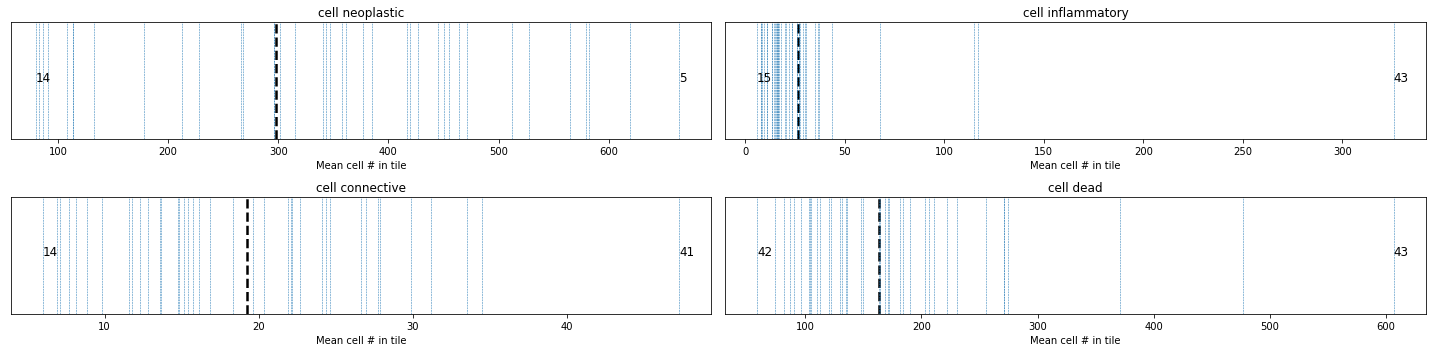

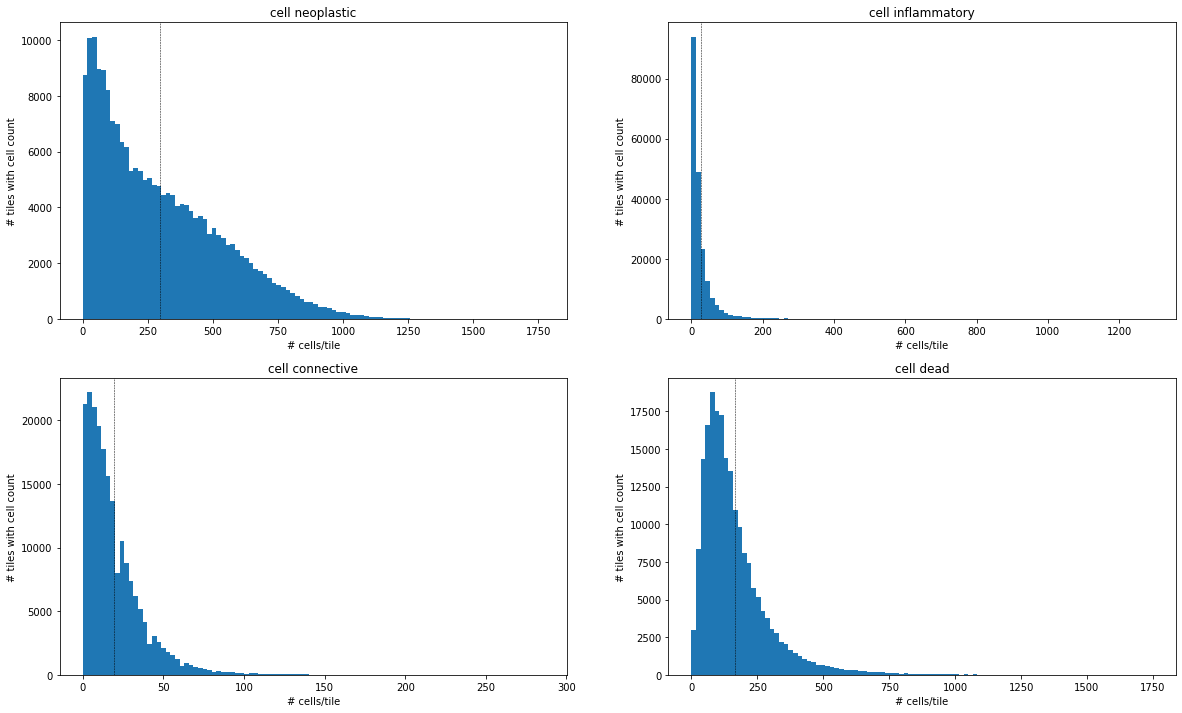

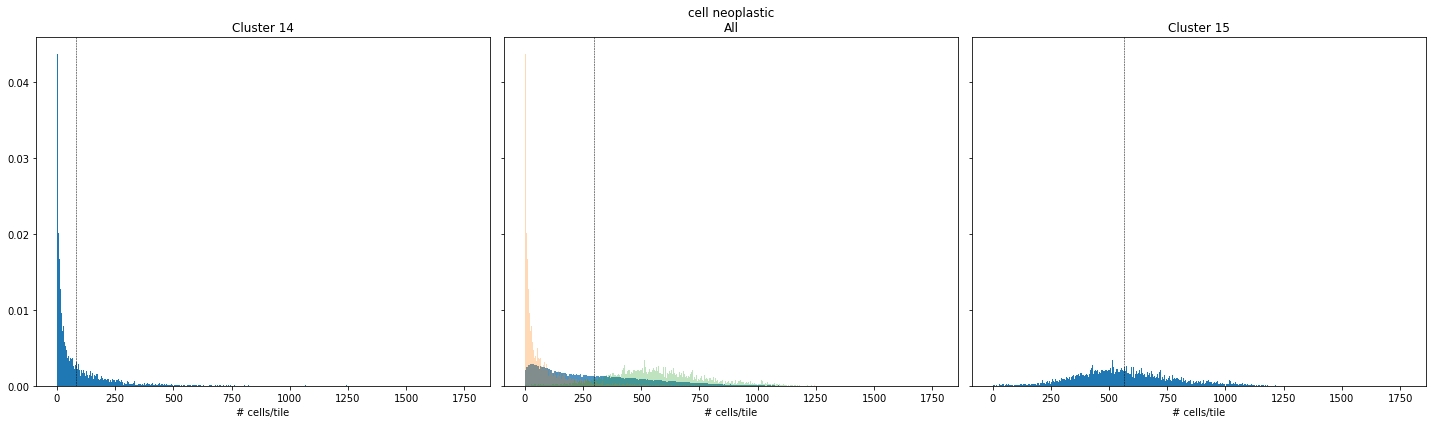

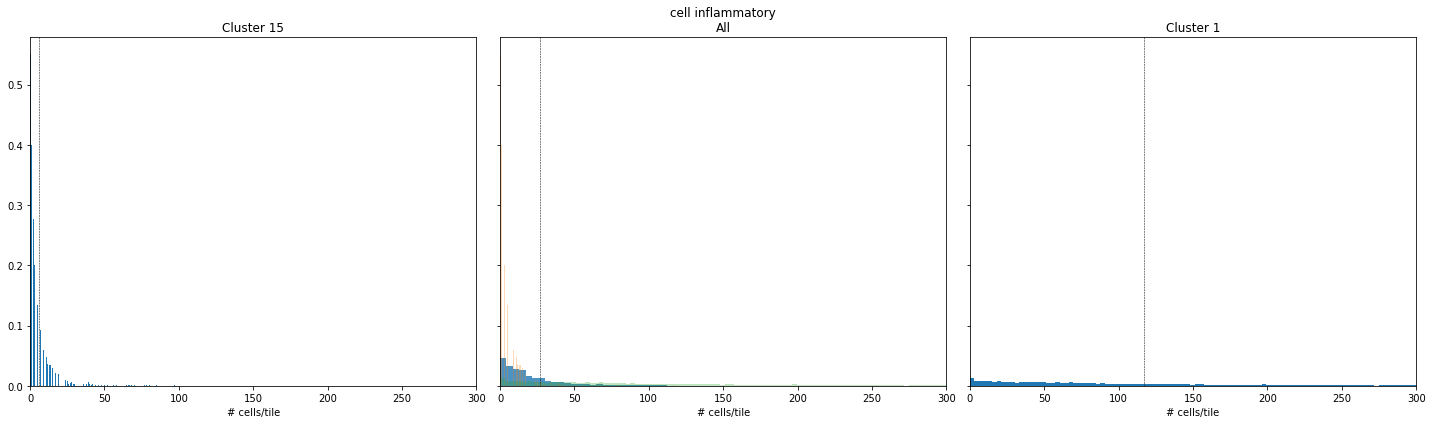

In [76]:
# cluster_of_interest = [0,13,31,36,43,1,9]
cluster_of_interest = [15,11,14,6]

fig, axes = plt.subplots(ncols=2,nrows=2, sharex=False, sharey=False, figsize=(20,5))
for i, ax in enumerate(axes.flat):
    cell_name      = cell_names[i]
    max_count_cell = tile_reps[cell_name].max()
    min_count_cell = tile_reps[cell_name].min()
    for cluster_id in tile_reps.index.values:
        mean = tile_reps.loc[cluster_id, cell_name]
        if mean == max_count_cell or mean == min_count_cell:
            # if cluster_id in cluster_of_interest:
            ax.annotate(cluster_id, (mean,0.5), fontsize=12)
        if cluster_id == 'Mean':
            ax.axvline(mean, color='black', linestyle='dashed', linewidth=2.5)
        else:
            ax.axvline(mean, linestyle='dashed', linewidth=0.5)
        ax.set_title(cell_name)
        ax.set_yticks([])
        ax.set_xlabel('Mean cell # in tile')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(ncols=2,nrows=2, sharex=False, sharey=False, figsize=(20,12))
for i, ax in enumerate(axes.flat):
    cell_name = cell_names[i]
    mean = tile_reps.loc['Mean', cell_name]
    ax.axvline(mean, color='black', linestyle='dashed', linewidth=0.5)
    ax.hist(cluster_anno_df[cell_name].values, bins=100)
    ax.set_title(cell_name)
    ax.set_ylabel('# tiles with cell count')
    ax.set_xlabel('# cells/tile')


def plot_comparison(cell_name, cluster_id_0, cluster_id_1, set_df, tile_reps, x_max=None, bins=300):
    fig, ax = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=True, figsize=(20,6))

    mean = tile_reps.loc[cluster_id_0, cell_name]
    ax[0].axvline(mean, color='black', linestyle='dashed', linewidth=0.5)
    ax[0].hist(set_df[set_df[groupby]==cluster_id_0][cell_name].values, bins=bins, density=True)
    ax[0].set_title('Cluster %s' % cluster_id_0)
    ax[0].set_xlabel('# cells/tile')
    if x_max is not None:
        ax[0].set_xlim([0, x_max])

    mean = tile_reps.loc['Mean', cell_name]
    ax[1].axvline(mean, color='black', linestyle='dashed', linewidth=0.5)
    ax[1].hist(set_df[cell_name].values, bins=bins, density=True, alpha=0.8)
    ax[1].set_title('%s\nAll'%cell_name)
    ax[1].set_xlabel('# cells/tile')
    ax[1].hist(set_df[set_df[groupby]==cluster_id_0][cell_name].values, bins=bins, density=True, alpha=0.3)
    ax[1].hist(set_df[set_df[groupby]==cluster_id_1][cell_name].values, bins=bins, density=True, alpha=0.3)

    mean = tile_reps.loc[cluster_id_1, cell_name]
    ax[2].axvline(mean, color='black', linestyle='dashed', linewidth=0.5)
    ax[2].hist(set_df[set_df[groupby]==cluster_id_1][cell_name].values, bins=bins, density=True)
    ax[2].set_title('Cluster %s' % cluster_id_1)
    ax[2].set_xlabel('# cells/tile')
    plt.tight_layout()
    plt.show()

plot_comparison(cell_names[0], 14, 15,  cluster_anno_df, tile_reps, x_max=None)
plot_comparison(cell_names[1], 15, 1, cluster_anno_df, tile_reps, x_max=300)
# plot_comparison(cell_names[4], 40, 3,  cluster_anno_df, tile_reps, x_max=None)
